
# Diseño de software
----

### Unidad 3: Mocks, substitutes y duplicates


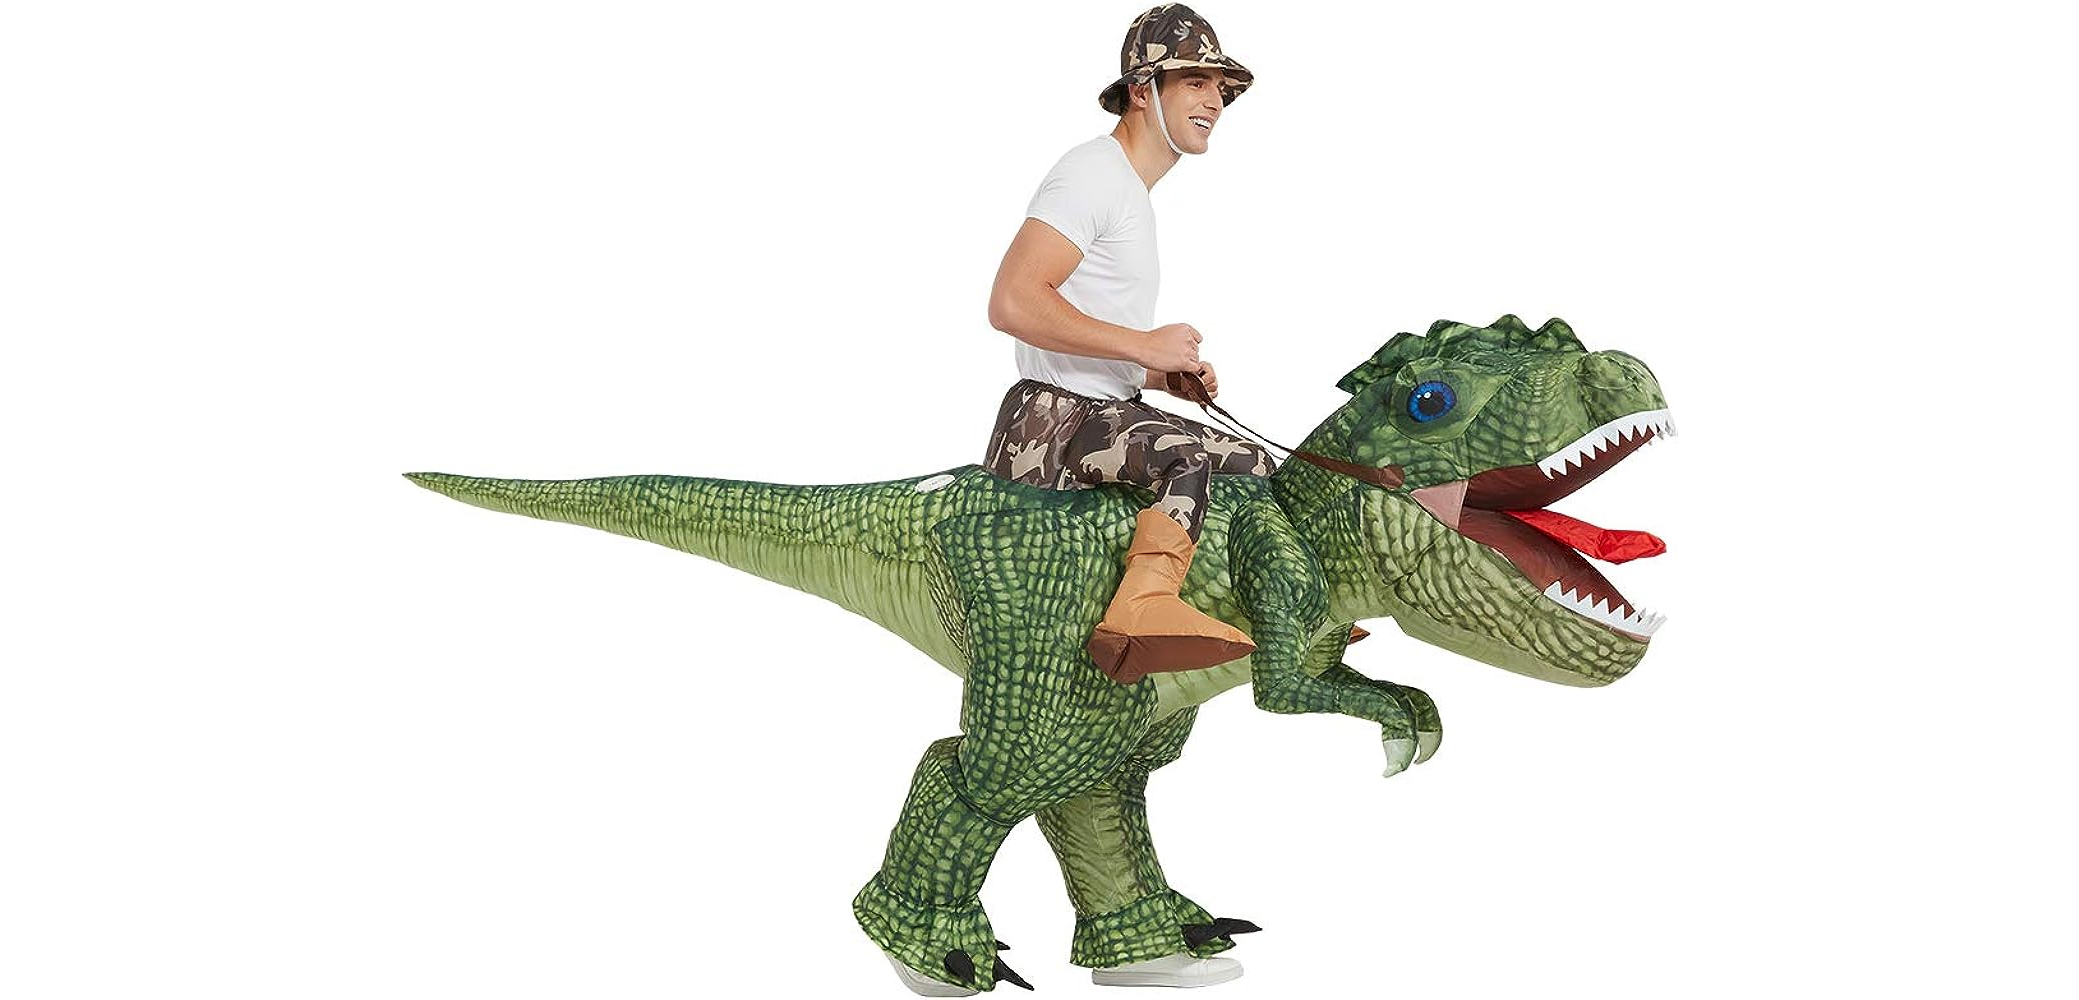


----
<small>
    <b>Fuente: </b><a href="https://es.slideshare.net/surajssd009005/python-testing-using-mock-and-pytest">https://es.slideshare.net/surajssd009005/python-testing-using-mock-and-pytest</a></small>

## Intro - IO Tests

Supongamos que queremos probar las funcionalidades de `read_txt()` y `to_txt()`, pero nos molesta que escribamos en disco

In [1]:
def read_txt(path):
    with open(path, "r") as fp:
        return fp.read()

def to_txt(path, text):
    with open(path, "w") as fp:
        return fp.write(text)

def test_read_to_txt():
    text = "hola"
    to_txt("algo.txt", text)
    assert read_txt("algo.txt") == text

test_read_to_txt()

## Intro - IO Tests

Podemos diseñar mejor las funciones para que soporten, lectura y escritura no solo de *paths* sino de *file-like* objects.

In [2]:
def read_txt(path_or_buff):
    if isinstance(path_or_buff, str):
        with open(path_or_buff, "r") as fp:
            return fp.read()
    return path_or_buff.read()


def to_txt(path_or_buff, text):
    if isinstance(path_or_buff, str):
        with open(path_or_buff, "w") as fp:
            return fp.write(text)
    return path_or_buff.write(text)


def test_read_to_txt():
    text = "hola"
    with open("algo2.txt", "w") as fp:
        to_txt(fp, text)
    assert read_txt("algo2.txt") == text

test_read_to_txt()

## Intro - IO Tests

Este nuevo diseño nos permite reemplazar el archivo real por un duplicado que no escribe a disco.

In [3]:
import io

def read_txt(path_or_buff):
    if isinstance(path_or_buff, str):
        with open(path_or_buff, "r") as fp:
            return fp.read()
    return path_or_buff.read()


def to_txt(path_or_buff, text):
    if isinstance(path_or_buff, str):
        with open(path_or_buff, "w") as fp:
            return fp.write(text)
    return path_or_buff.write(text)

def test_read_to_txt():
    text = "hola"
    buff = io.StringIO()
    to_txt(buff, text)
    buff.seek(0)
    assert read_txt(buff) == text, "los textos no salen iguales"

test_read_to_txt()

## Mock - `unittest.mock`

> *Defn:* `unittest.mock` es una biblioteca para testing en Python. 
Permite reemplazar partes de un sistema bajo prueba con
objetos sinteticos y hacer afirmaciones sobre cómo han
ha sido usado.

- Usando Mock se puede reemplazar/simular cualquier dependencia del código.
- Remplazar partes de ejecución costosa o poco confiables.
- Sirve para evaluar la correcta de ejecucón de las funciones desarrolladas en lugar de llegar hasta el resultado final.
- Mock tambien acelera código lento reemplazandolo por llamadas.

## Mock básico

In [4]:
from unittest.mock import Mock

m = Mock()
m

<Mock id='140091903284592'>

In [5]:
m.some_value = 23
m.some_value

23

In [6]:
m.other_value.otro  # una vez accedido devuelve el mismo (Ver id)

<Mock name='mock.other_value.otro' id='140091903875424'>

## Mock básico

In [7]:
m.get_value(value=42)

<Mock name='mock.get_value()' id='140091903876576'>

In [8]:
m.get_value.assert_called()

In [10]:
m.get_value.assert_called_once_with(value=42)

## Más sobre los objetos Mock

- Pueden reemplazar cualquier parte de código.
- Crea atriburos a medida que se accede a ellos.
- Recuerda como fueron accedidos esos atributos.
- Genera `asserts` basado en esa historia de acceso.

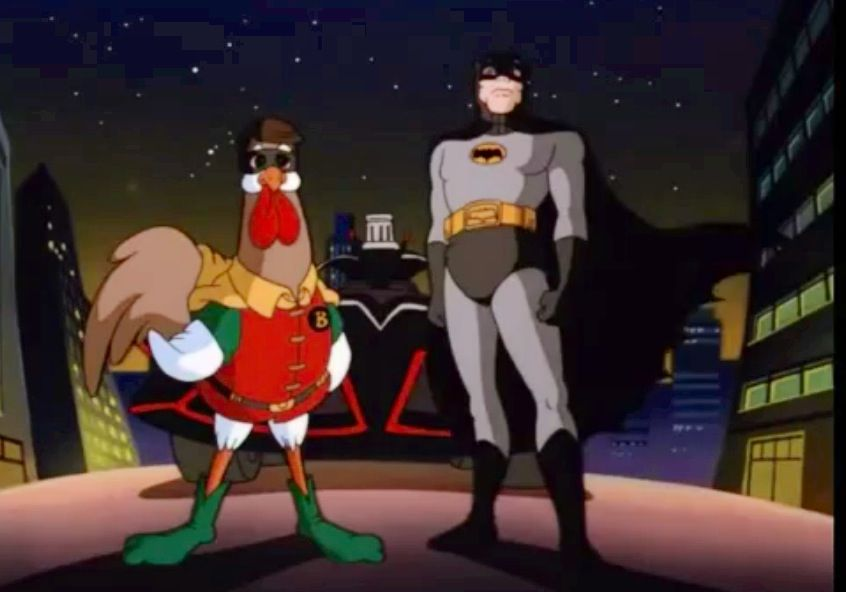

## Personalización de Mocks

- Sirve para restringir el comportamiento de los mocks
- Se puede definir atributos o métodos (con puntos en el nombre)

In [11]:
config = {
    'company': 'Lenovo',
    'model': 'Ideapad Z510',
    'get_sticker_count.return_value': 11,
    'get_fan_speed.side_effect': ValueError
}

m = Mock(**config)
m.company2

<Mock name='mock.company2' id='140091903877584'>

In [12]:
m.get_sticker_count()

11

In [13]:
m.get_fan_speed()

ValueError: 

## Usando spec para definir atributos

- Es un poco menos granular pero define exactamente que atributos estan disponibles.
- Cada atributo creado a su vez es un mock.

In [15]:
user_info = ['first_name', 'last_name', 'email']

m = Mock(spec=user_info)
m.first_name

<Mock name='mock.first_name' id='140091409657200'>

In [16]:
m.last_name

<Mock name='mock.last_name' id='140091409652016'>

## Creación automática de specs

- Copia el contenido de otro objeto.
- Reemplaza los valores por mock

In [17]:
from unittest.mock import create_autospec
import io
import os
m = create_autospec(io.TextIOWrapper)
m

<MagicMock spec='TextIOWrapper' id='140091409654656'>

In [19]:
m.close()

<MagicMock name='mock.close()' id='140091407526800'>

## Servidor de números aleatorios

- Voy a utilizar un framework web que se llama **bottle**.
- Un framework es una librería que no te brinda control de su ejecución pero te perminte interferir su funcionamiento para injectar valores.
- Emulemos algo del tipo: https://www.random.org/

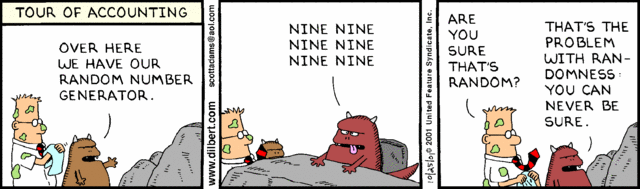

## Servidor de números aleatorios

- Yoy a correr un mini servidor de numeros aleatorios en mi propia compu (`code/server.py`)
- Se corre con `python 03_mock_code/server.py`

```python
import time
import numpy as np
import bottle  # pip install bottle

app = bottle.Bottle()

@app.route("/random")
def random():
    time.sleep(np.random.randint(0, 1) + np.random.rand())
    return str(np.random.rand())

if __name__ == "__main__":
    app.run(host='localhost', port=5000, debug=True)
```

## Pidamos los números aleatorios.

> Juan: Acordate de poner la terminal del server 

In [ ]:
%%time

import requests # pip install requests
response = requests.get("http://localhost:5000/random")

print(response, "-", f"Random={response.text}")
print("-" * 80)

## Creemos un dado de 100 caras

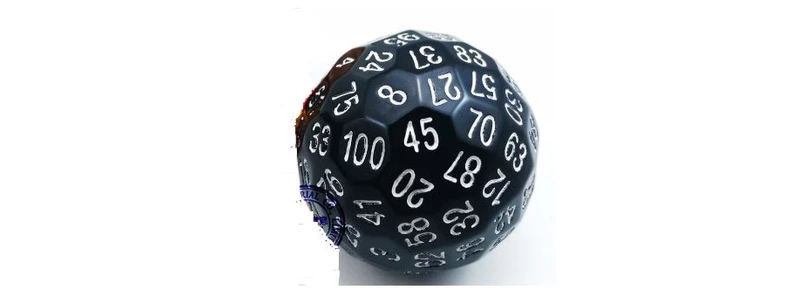

In [ ]:
def roll(success):
    response = requests.get("http://localhost:5000/random")
    value = float(response.text)
    print(F"[Debug] {value}")
    return success <= value

roll(.8)

## Probando el d100

- Lo que se quiere probar es que devuelva `True` si el valor retornado por el servidor es menor que `success`, y `False` en el caso contrario.
- No tenemos control sobre el servidor.
- Solo desarrollamos `roll`. 

In [ ]:
# code/test_dice.py

def test_win():
    assert roll(1.)
    assert roll(.8)
    assert roll(.1)

def tesst_lose():
    assert not roll(1.)
    assert not roll(.8)
    assert not roll(.1)


## Usando mock con patch

- `patch()` substituye un objeto con mock según su nombre completo (*nombre.completo.del.objeto*)
- Puede usarse como un decorator/context manager.


In [ ]:
# code/test_roll.py

def test_win():
    response = mock.Mock(text="1")
    with mock.patch("requests.get", return_value=response) as mget:
        assert roll(1.)
        assert roll(.8)
        assert roll(.1)
    mget.assert_called()


def test_lose():
    response = mock.Mock(text="0")
    with mock.patch("requests.get", return_value=response) as mget:
        assert not roll(1.)
        assert not roll(.8)
        assert not roll(.1)
    mget.assert_called()

## Usando mock con patch

- Como decorador sirve para envolver cosas mas grandes o por ejemplo.

In [ ]:
# code/test_roll_dec.py

@mock.patch("requests.get", return_value=mock.Mock(text="1"))
def test_win(mget):
    assert roll(1.)
    assert roll(.8)
    assert roll(.1)
    mget.assert_called()


@mock.patch("requests.get", return_value=mock.Mock(text="0"))
def test_lose(mget):
    assert not roll(1.)
    assert not roll(.8)
    assert not roll(.1)
    mget.assert_called()

## Volviendo al comienzo!

Para lograr el 100% de coverage vamos a necesitar probar tambien la parte de `isinstance(path_or_buff, str)`

In [68]:
from unittest import mock; import io

def read_txt(path_or_buff):
    if isinstance(path_or_buff, str):
        with open(path_or_buff, "r") as fp:
            return fp.read()
    return path_or_buff.read()

def test_read_to_txt_buff():
    text = "hola"
    buff = io.StringIO()
    to_txt(buff, text)
    buff.seek(0)
    assert read_txt(buff) == text, "los textos no salen iguales"

def test_read_to_txt_path():
    path, text = "mypath.txt", "hola"
    mopen = mock.mock_open()
    with mock.patch('__main__.open', mopen):
        to_txt(path, text)
    mopen.assert_called_once_with(path, 'w')
    mopen().write.assert_called_once_with(text)

    mopen = mock.mock_open(read_data=text)
    with mock.patch('__main__.open', mopen):
        readed = read_txt(path)
    assert readed == text

test_read_to_txt_buff()
test_read_to_txt_path()

## Cerrando

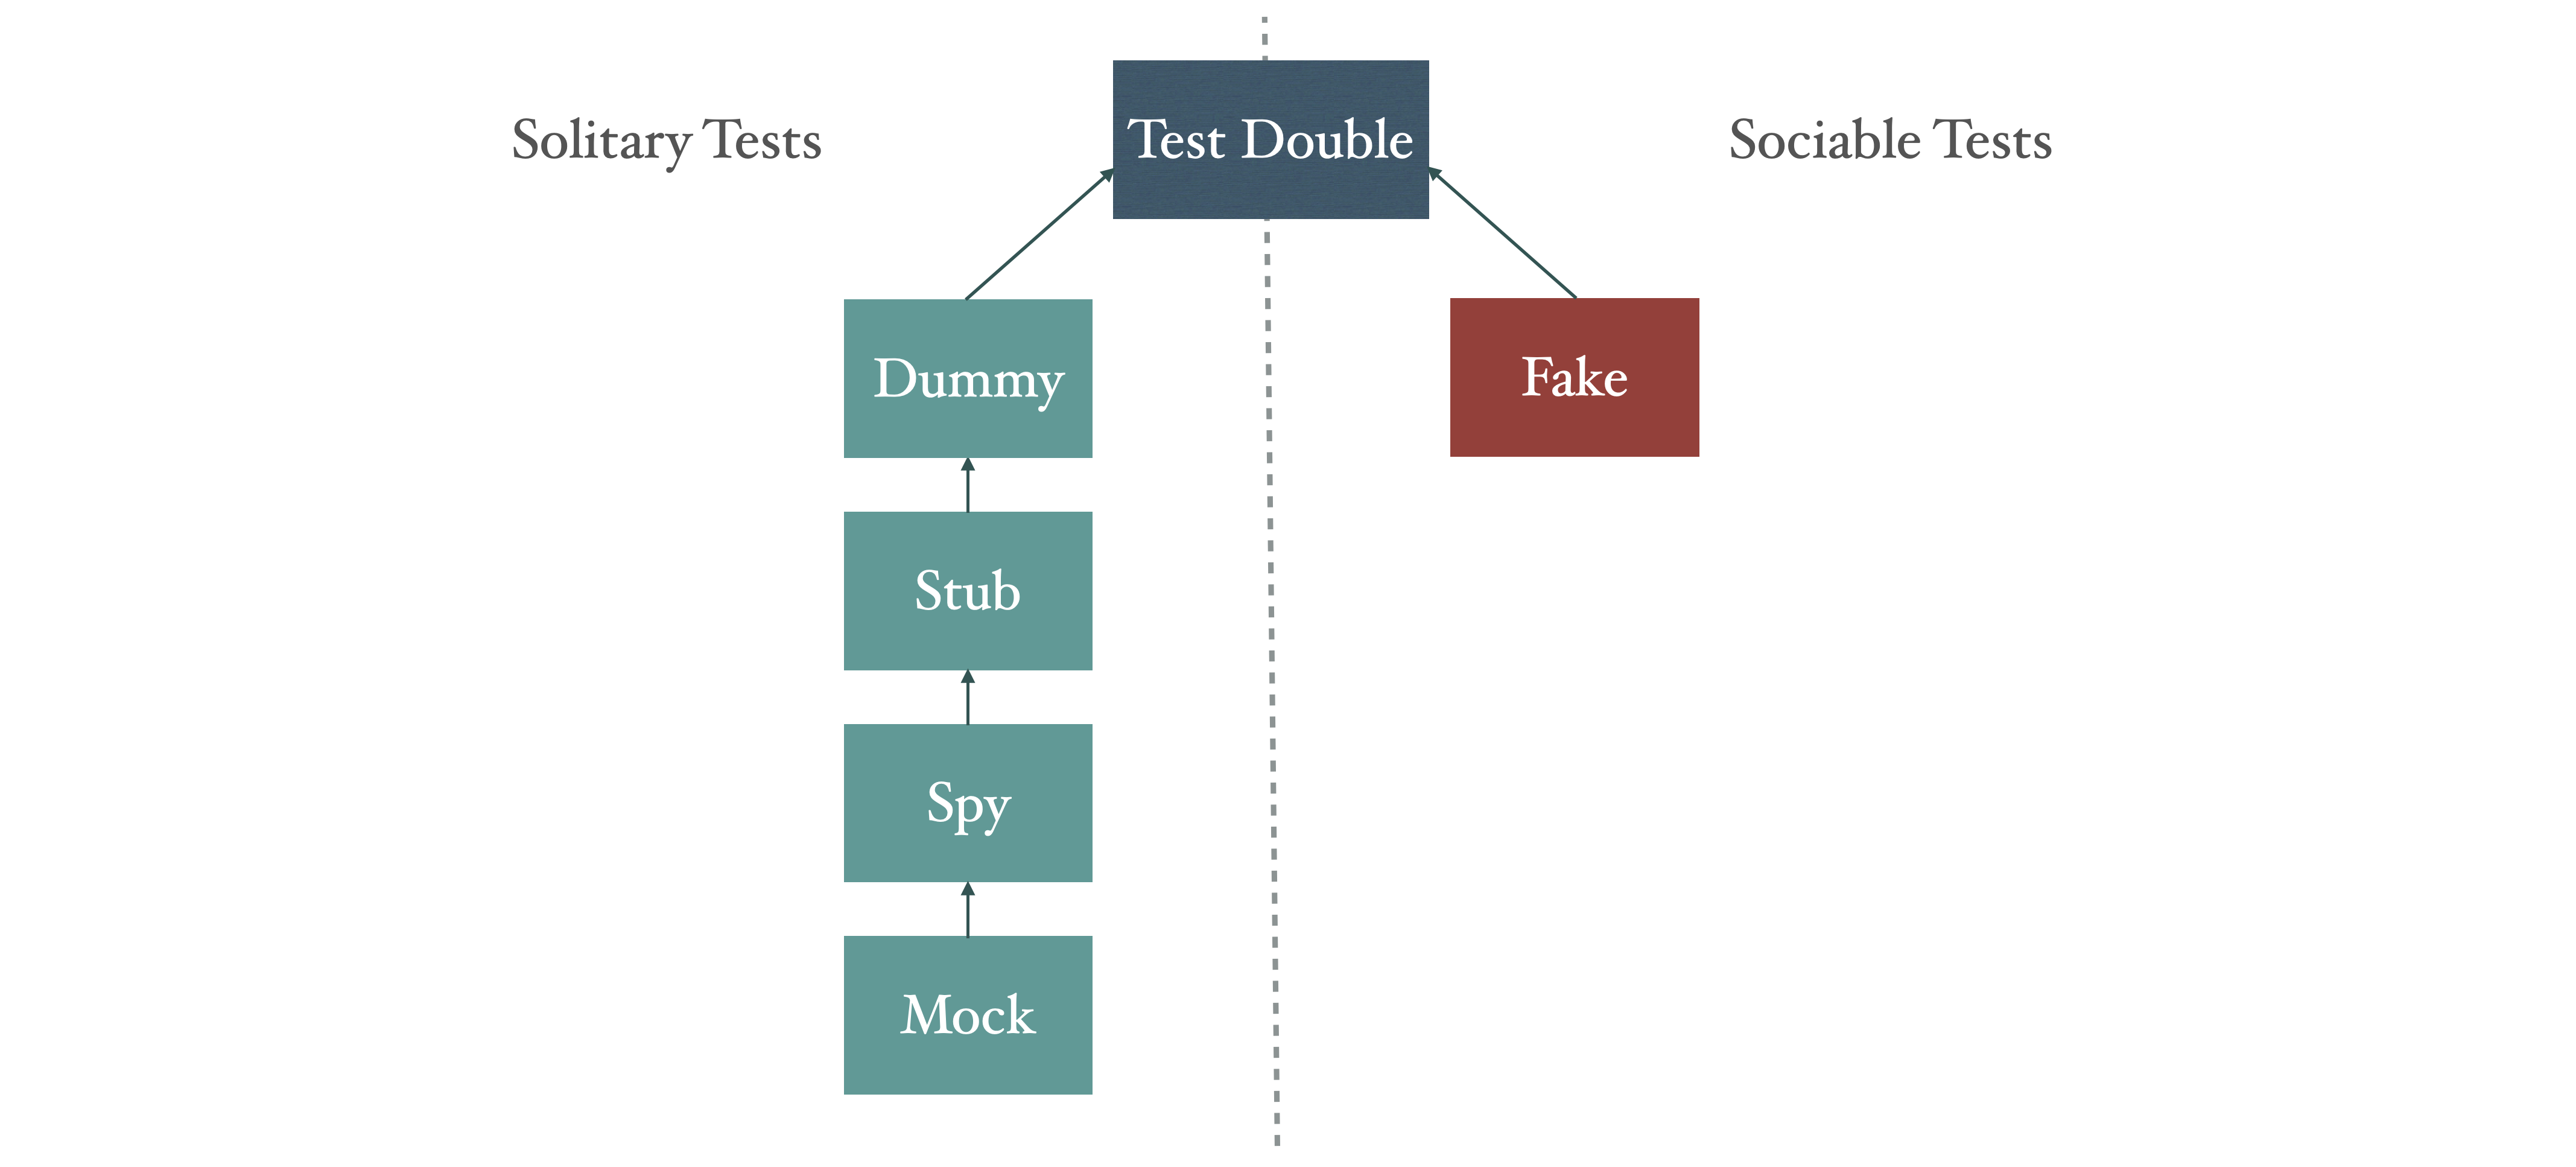

More info https://principal-it.eu/2020/04/test-doubles/